# AI-Generated Images vs. Real Images Classification

## Introduction
With the rise of artificial intelligence (AI) capabilities in generating realistic images, distinguishing between AI-generated images and real images has become increasingly challenging. This project aims to develop a deep learning model capable of accurately classifying images into two categories: AI-generated and real images.

### Motivation & Challenges
The proliferation of AI-generated content across various platforms raises concerns about misinformation and authenticity. Robust classification models are crucial for verifying the authenticity of images in applications such as content moderation, forensic analysis, and deepfake detection. However, distinguishing between AI-generated and real images poses several challenges, including the rapid advancement of AI technology, the diversity of image styles and content, and the potential for subtle differences between AI-generated and real images.

### Approach
The proposed approach involves leveraging convolutional neural networks (CNNs), a powerful deep learning architecture widely used for image classification tasks. By training a CNN on a dataset containing both AI-generated and real images, the model will learn to differentiate between the two categories based on their distinct features and characteristics.

### Baselines
As a baseline, we utilize the LeNet-5 architecture. In addition to this, we have developed a custom convolutional neural network (CNN) and employed a Support Vector Machine (SVM). The SVM is trained using features extracted from a pre-trained ResNet model. This setup allows us to comprehensively evaluate the performance of our custom CNN against both oldschool Deep Learning model Lenet-5 and the state-of-the-art ResNet used as feature extractor for SVM.

### Dataset
The dataset for this project consists of a curated collection of AI-generated images and real images sourced from Kaggle. The dataset includes diverse image categories and encompasses a range of styles, resolutions, and content types to ensure model robustness and generalization. Specifically, the dataset is a captivating ensemble of images sourced from two distinct channels: web scraping and AI-generated content. The content covers many subjects with special emphasis on the following topics:
- People
- Animals
- Portraits
- Scenery
- Psychedelics

The dataset comprises 436 "Real" images and 539 AI-generated images. Upon examining the dataset, we observed that many of the AI-generated images contained credentials in the bottom right corner, which necessitated cropping. Additionally, some images were a concatenated result of four separate images, as suggested by the generative frameworks based on prompt engineering. We decided to divide these concatenated images into four distinct images. Moreover, we excluded some images that were deemed out of context or appeared as screenshots showcasing the entire generative AI framework.

As a result, our final dataset consists of 400 "Real" images and 469 AI-generated images for training, with 30 "Real" and 30 AI-generated images in the test set.

Furthermore, we manually constructed an additional test set ("my_test") using the same sources as the Kaggle dataset to ensure consistency and comprehensiveness in our evaluation. This supplementary dataset includes 35 AI-generated images prompted by us and 35 real images captured by an artistic photographer

### Metrics
Performance evaluation will be conducted using standard classification metrics such as accuracy, precision, recall, and F1 score. Additionally, Receiver Operating Characteristic (ROC) curves and Area Under the Curve (AUC) scores will provide insights into model discrimination capabilities and performance across different thresholds.

### Imports

In [ ]:
import os
import random
import time
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, auc, roc_curve, precision_recall_fscore_support, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from itertools import product
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image

generator1 = torch.Generator().manual_seed(42)
warnings.filterwarnings("ignore", category=UserWarning, message="Palette images with Transparency expressed in bytes should be converted to RGBA images")

## Dataset

Before diving into data preprocessing and model training, it's important to inspect the dataset to understand its structure and contents. This section includes loading the dataset, displaying sample images, and analyzing the distribution of images across different classes.

### Loading the Dataset

Class distribution: {'RealArt': 400, 'AiArtData': 469}


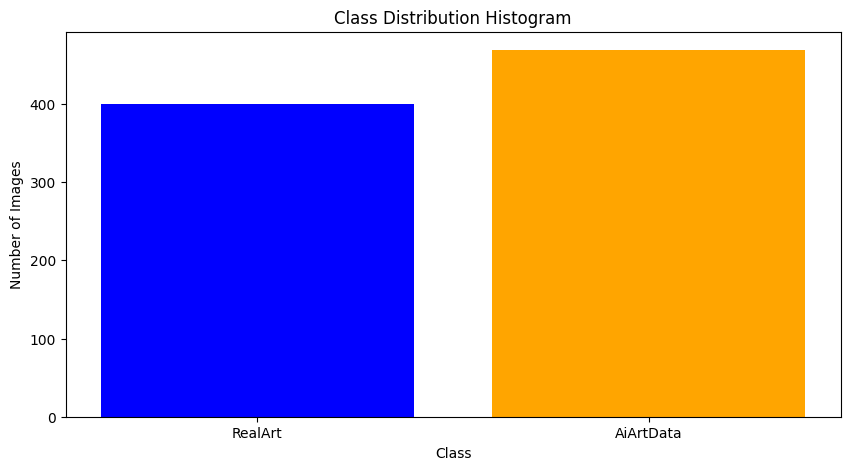

In [ ]:
dataset_path = '/content/drive/MyDrive/train_val'

class_counts = {}

class_dirs = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

for class_dir in class_dirs:
    class_path = os.path.join(dataset_path, class_dir)
    num_files = len([name for name in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, name))])
    class_counts[class_dir] = num_files

print(f"Class distribution: {class_counts}")

plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color=['blue', 'orange'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution Histogram')
plt.show()

### Displaying Sample Images

Class: RealArt


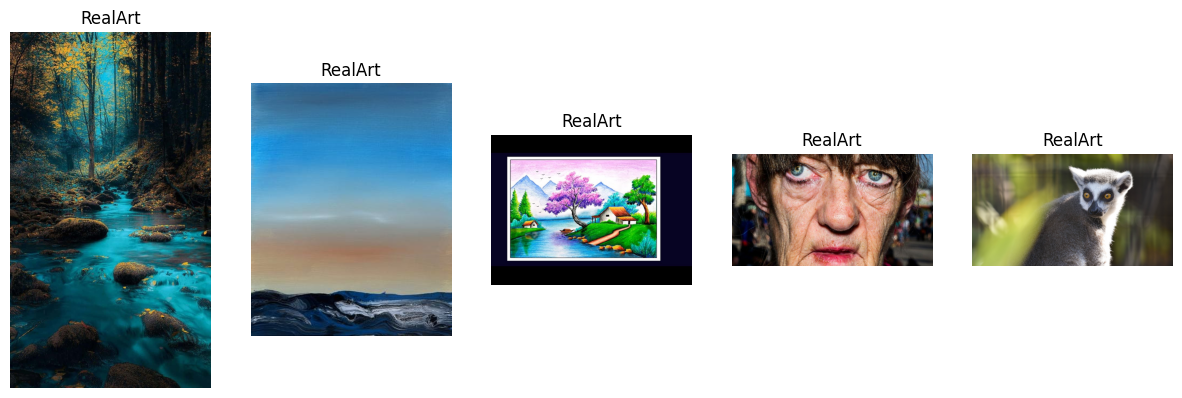

Class: AiArtData


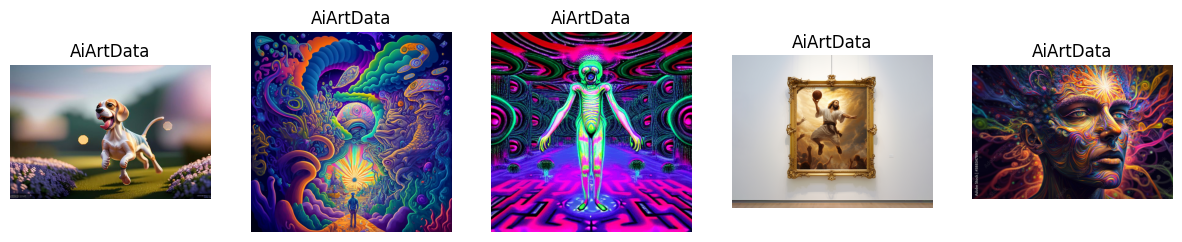

In [ ]:
dataset_path = '/content/drive/MyDrive/train_val'

class_paths = {}

class_dirs = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

for class_dir in class_dirs:
    class_path = os.path.join(dataset_path, class_dir)
    class_paths[class_dir] = [os.path.join(class_path, f) for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

def display_random_images(class_paths, num_images):
    for class_name, paths in class_paths.items():
        print(f"Class: {class_name}")
        random_images = random.sample(paths, min(num_images, len(paths)))

        plt.figure(figsize=(15, 5))
        for i, img_path in enumerate(random_images):
            img = Image.open(img_path)
            plt.subplot(1, num_images, i+1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')
        plt.show()

display_random_images(class_paths, num_images=5)


## Data Preprocessing

Data preprocessing is a crucial step in any machine learning pipeline, especially for image classification tasks. In this project, we implement data augmentation to address the data requirements of deep convolutional neural networks, thereby enhancing the model's ability to generalize effectively.

### Data Augmentation

Data augmentation is used to artificially increase the size of the training dataset by creating modified versions of images in the dataset. This helps improve the model's ability to generalize and perform well on unseen data. The following augmentations were applied:

1. **Vertical Flip**: This transformation mirrors the image.
2. **Rotation**: This transformation rotates the image by ±15 degrees.
3. **Random Crop**: This transformation crops a random portion of the image and resizes it to 512x512 pixels.
4. **Gaussian Noise**: This transformation adds random Gaussian noise to the image.

The following script performs data augmentation on the input dataset:


In [ ]:
def augment_and_save(image_tensor, transform, save_path, class_name, original_extension, augmentation_type, counter):
    image = transforms.ToPILImage()(image_tensor)
    augmented_image = transform(image)
    augmented_image.save(os.path.join(save_path, f"{class_name}_img_{augmentation_type}_{counter}{original_extension}"))

def data_augmentation(input_dir, output_dir):
    vertical_flip = transforms.Compose([
        transforms.RandomHorizontalFlip(p=1.0), # Mirror
    ])

    rotation = transforms.Compose([
        transforms.RandomRotation(15),  # Rotate by ±15 degrees
    ])

    random_crop = transforms.Compose([
        transforms.RandomResizedCrop(size=(512, 512), scale=(0.8, 1.0)),  # Crop
    ])

    gaussian_noise = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.1),  # Add Gaussian noise
        transforms.ToPILImage()
    ])

    dataset = datasets.ImageFolder(root=input_dir, transform=transforms.Compose([transforms.ToTensor()]))
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    class_name_mapping = {
        0: "ai_aug",
        1: "real_aug"}

    for idx, (inputs, labels) in enumerate(dataloader):
        label = labels.item()
        class_name = class_name_mapping[label]
        class_dir = os.path.join(output_dir, class_name)

        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        original_file_path = dataset.samples[idx][0]
        original_extension = os.path.splitext(original_file_path)[1]

        augment_and_save(inputs[0], vertical_flip, class_dir, class_name, original_extension, "flip", idx + 1)
        augment_and_save(inputs[0], rotation, class_dir, class_name, original_extension, "rotation", idx + 1)
        augment_and_save(inputs[0], random_crop, class_dir, class_name, original_extension, "crop", idx + 1)
        augment_and_save(inputs[0], gaussian_noise, class_dir, class_name, original_extension, "noise", idx + 1)

input_directory = '/content/drive/MyDrive/train_val'
output_directory = '/content/drive/MyDrive/augmentation_train_val'

data_augmentation(input_directory, output_directory)

Let's visualize some of the augmented images from each class to ensure that the augmentations have been applied correctly.

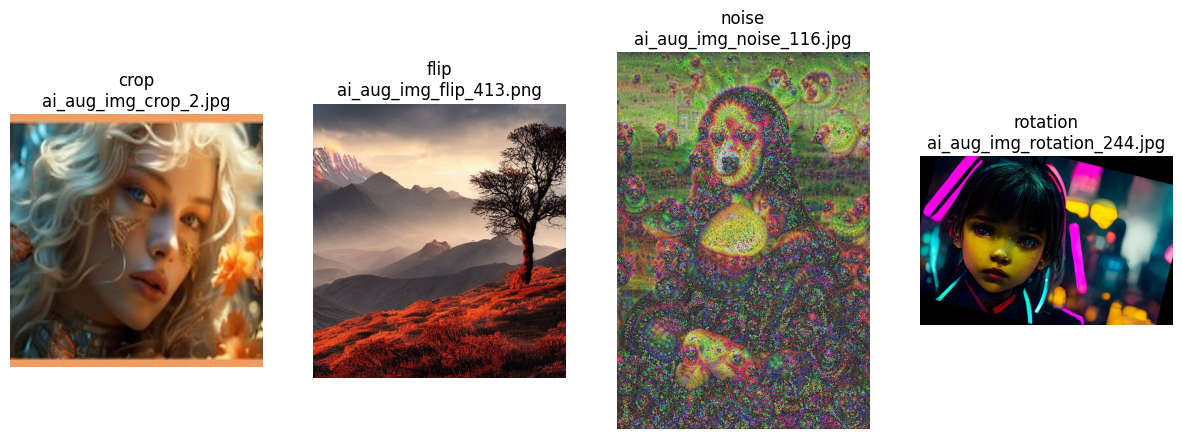

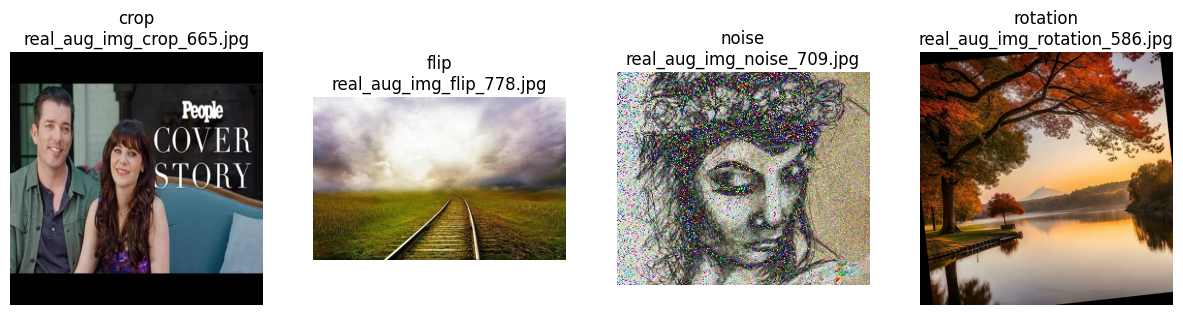

In [ ]:
def show_augmented_images(folder_path, class_name):
    class_path = os.path.join(folder_path, class_name)

    augmentations = ['crop', 'flip', 'noise', 'rotation']

    plt.figure(figsize=(15, 5))
    for i, augmentation in enumerate(augmentations):
        images = [img for img in os.listdir(class_path) if img.startswith(f'{class_name}_img_{augmentation}_')]

        img_name = random.choice(images)
        img_path = os.path.join(class_path, img_name)
        image = Image.open(img_path)

        plt.subplot(1, len(augmentations), i+1)
        plt.imshow(image)
        plt.title(f'{augmentation}\n{img_name}')
        plt.axis('off')
    plt.show()

augmented_folder = '/content/drive/MyDrive/augmentation_train_val'

for class_name in ['ai_aug', 'real_aug']:
    show_augmented_images(augmented_folder, class_name)

### Feature Extraction

Feature extraction is the process of transforming raw images into numerical features that can be used by machine learning models(SVM later in the project). In this project, we use a pre-trained ResNet-18 model to extract features from the images. The last fully connected layer of the ResNet-18 model is removed, and the output from the penultimate layer is used as the feature representation of the images. Due to the specific focus of this project on Deep Learning, we will not be conducting further analysis on the extracted data.

The following script performs feature extraction:


In [ ]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 as required by ResNet
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the original dataset
original_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/train_val', transform=transform)

# Load the augmented dataset
augmented_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/augmentation_train_val', transform=transform)

# Combine the original and augmented datasets
combined_dataset = ConcatDataset([original_dataset, augmented_dataset])
dataloader = DataLoader(combined_dataset, batch_size=32, shuffle=False)

# Load the my_test dataset
my_test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/my_test', transform=transform)
my_test_dataloader = DataLoader(my_test_dataset, batch_size=32, shuffle=False)

# Load the test dataset
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/test_data', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load a pre-trained ResNet model
model = models.resnet18(pretrained=True)
model.eval()

# Remove the last fully connected layer
model = nn.Sequential(*list(model.children())[:-1])

def extract_features(dataloader, model):
    features = []
    labels = []
    with torch.no_grad():
        for images, label_batch in dataloader:
            outputs = model(images)
            outputs = outputs.view(outputs.size(0), -1)
            features.append(outputs.cpu().numpy())
            labels.append(label_batch.cpu().numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

#---------------------------------
# Start the timer for training set
start_time_train = time.time()

features_train, labels_train = extract_features(dataloader, model)

end_time_train = time.time()
elapsed_time_train = end_time_train - start_time_train
#---------------------------------

hours_train, rem_train = divmod(elapsed_time_train, 3600)
minutes_train, seconds_train = divmod(rem_train, 60)
print(f"Training set feature extraction completed in {int(hours_train)}h {int(minutes_train)}m {int(seconds_train)}s")

unique_train, counts_train = np.unique(labels_train, return_counts=True)
print(f"Training set class distribution: {dict(zip(unique_train, counts_train))}")

df_features_train = pd.DataFrame(features_train)
df_labels_train = pd.DataFrame(labels_train, columns=['label'])
df_train = pd.concat([df_features_train, df_labels_train], axis=1)
df_train.to_csv('/content/drive/MyDrive/features.csv', index=False)

#--------------------------------
# Start the timer for my_test set
start_time_test = time.time()

features_test, labels_test = extract_features(my_test_dataloader, model)

end_time_test = time.time()
elapsed_time_test = end_time_test - start_time_test
#--------------------------------

hours_test, rem_test = divmod(elapsed_time_test, 3600)
minutes_test, seconds_test = divmod(rem_test, 60)
print(f"'My' Test set feature extraction completed in {int(hours_test)}h {int(minutes_test)}m {int(seconds_test)}s")

df_features_test = pd.DataFrame(features_test)
df_labels_test = pd.DataFrame(labels_test, columns=['label'])
df_test = pd.concat([df_features_test, df_labels_test], axis=1)
df_test.to_csv('/content/drive/MyDrive/my_test_features.csv', index=False)

#-----------------------------
# Start the timer for test set
start_time_test = time.time()

features_test, labels_test = extract_features(test_dataloader, model)

end_time_test = time.time()
elapsed_time_test = end_time_test - start_time_test
#-----------------------------

hours_test, rem_test = divmod(elapsed_time_test, 3600)
minutes_test, seconds_test = divmod(rem_test, 60)
print(f"Test set feature extraction completed in {int(hours_test)}h {int(minutes_test)}m {int(seconds_test)}s")

df_features_test = pd.DataFrame(features_test)
df_labels_test = pd.DataFrame(labels_test, columns=['label'])
df_test = pd.concat([df_features_test, df_labels_test], axis=1)
df_test.to_csv('/content/drive/MyDrive/test_features.csv', index=False)

print("Features and labels saved to features")

In [ ]:
features_path = (r'/content/drive/MyDrive/features.csv')
df = pd.read_csv(features_path)
df.describe()

0            1            2            3            4  \
count  4340.000000  4340.000000  4340.000000  4340.000000  4340.000000   
mean      1.152716     0.714119     0.807810     1.272265     0.722256   
std       0.862080     0.603603     0.725984     0.927401     0.733112   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.513689     0.258092     0.273517     0.579686     0.213189   
50%       0.961974     0.574511     0.621400     1.077324     0.500592   
75%       1.612571     0.998018     1.132797     1.769622     0.973465   
max       5.523542     3.939686     6.135413     6.042779     5.945470   

                 5            6            7            8            9  ...  \
count  4340.000000  4340.000000  4340.000000  4340.000000  4340.000000  ...   
mean      0.594358     0.953477     1.698812     1.557180     1.094380  ...   
std       0.610020     0.790465     1.351550     1.275324     0.854841  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.161489     0.335655     0.710045     0.634000     0.473744  ...   
50%       0.408300     0.768376     1.346633     1.187380     0.901211  ...   
75%       0.833977     1.373900     2.335346     2.096103     1.523106  ...   
max       7.136322     4.848715     9.176626     7.098560     7.736774  ...   

               503          504          505          506          507  \
count  4340.000000  4340.000000  4340.000000  4340.000000  4340.000000   
mean      0.887713     0.842292     0.853019     0.978800     0.737055   
std       0.719957     0.671973     0.670802     0.908782     0.697601   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.325337     0.333164     0.348602     0.258883     0.219114   
50%       0.736349     0.688965     0.690623     0.729333     0.555501   
75%       1.283254     1.208269     1.185865     1.451859     1.052894   
max       5.774670     4.397047     4.640953     5.379345     5.895266   

               508          509          510          511        label  
count  4340.000000  4340.000000  4340.000000  4340.000000  4340.000000  
mean      0.726401     1.908718     0.617691     1.088922     0.459677  
std       0.594608     1.117052     0.732600     0.846841     0.498429  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.263840     1.080437     0.128578     0.429529     0.000000  
50%       0.581543     1.729515     0.379908     0.913608     0.000000  
75%       1.025430     2.574659     0.856838     1.559376     1.000000  
max       3.480851     7.208005     8.103210     6.093280     1.000000  

[8 rows x 513 columns]

In [ ]:
df.head()

0         1         2         3         4         5         6  \
0  2.115125  0.245477  2.208354  2.331572  0.022493  0.607740  1.825656   
1  1.941415  0.500553  1.042234  0.822050  0.437246  0.343399  0.934002   
2  1.111963  0.710002  0.338012  2.677872  0.898456  0.678417  1.359133   
3  0.346452  0.324284  0.075721  2.188951  0.227324  1.343786  0.698328   
4  1.349003  0.404759  0.073332  1.012845  2.473880  0.069543  2.376218   

          7         8         9  ...       503       504       505       506  \
0  1.935151  0.302579  1.183348  ...  2.508818  1.628660  0.970166  1.070922   
1  2.063106  0.698019  1.407726  ...  1.979582  0.810975  0.283555  0.197969   
2  0.563220  1.473367  0.178723  ...  0.584941  0.686713  1.193168  2.775324   
3  0.316987  2.940587  0.177984  ...  1.229248  0.765027  1.973926  0.734102   
4  1.168257  1.176416  0.919212  ...  0.748154  0.001239  0.937120  0.611307   

        507       508       509       510       511  label  
0  0.937122  0.961232  2.614279  0.499259  1.399039      0  
1  0.790984  0.266956  2.870181  0.339885  1.640449      0  
2  1.575724  0.543859  1.498150  0.006034  1.015403      0  
3  1.098398  0.404520  1.615201  0.152052  1.149632      0  
4  1.552320  0.046309  2.601976  0.834057  1.527707      0  

[5 rows x 513 columns]

## Model Development

In this section, we develop and train different models to classify images as either AI-generated or real.

### LeNet-5

LeNet-5 is a classic convolutional neural network (CNN) architecture that has been widely used for image classification tasks. Originally designed to process 32x32 grayscale images (1 channel).

To facilitate a fair comparison between the baseline LeNet-5 model and a custom CNN architecture tailored for this project, we have made some adjustments to the core LeNet-5 architecture. Specifically, we modified LeNet-5 to accept RGB images (3 channels), which aligns with the input format used by our custom CNN model. This adjustment ensures that both models process the same type of input data, thereby enabling a more accurate and meaningful comparison.

Moreover, we maintained the original input size of 32x32 pixels. Given the relatively small architecture of LeNet-5, increasing the input size would be impractical and could lead to suboptimal performance. By fine-tuning the LeNet-5 architecture in this manner, we can effectively evaluate the performance of the baseline model against our custom CNN model under consistent and comparable conditions.

In [ ]:
class lenet(nn.Module):
    def __init__(self, num_classes=2):
        super(lenet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Linear(16 * 5 * 5, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [ ]:
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_lenet = lenet().to(device)
print(summary(model_lenet, (3, 32, 32), 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [32, 6, 28, 28]             456
       BatchNorm2d-2            [32, 6, 28, 28]              12
              ReLU-3            [32, 6, 28, 28]               0
         MaxPool2d-4            [32, 6, 14, 14]               0
            Conv2d-5           [32, 16, 10, 10]           2,416
       BatchNorm2d-6           [32, 16, 10, 10]              32
              ReLU-7           [32, 16, 10, 10]               0
         MaxPool2d-8             [32, 16, 5, 5]               0
            Linear-9                  [32, 120]          48,120
             ReLU-10                  [32, 120]               0
           Linear-11                   [32, 84]          10,164
             ReLU-12                   [32, 84]               0
           Linear-13                    [32, 2]             170
Total params: 61,370
Trainable params: 

### Custom Convolutional Neural Network

In this section, we define the architecture used in the project. Drawing inspiration from advanced architectures like ResNet, VGG, and Inception, we design a deep convolutional neural network (CNN) that strategically employs large kernels in the initial layers to capture broad and general features from the images. As the network deepens, smaller kernels are utilized to preserve and extract finer details, ensuring that both high-level abstract features and low-level intricate patterns are effectively captured.

This architectural approach leverages the strengths of various successful paradigms in deep learning. For instance, similar to ResNet, our model incorporates deeper layers to learn complex representations. Inspired by VGG, we use smaller kernels in the deeper layers to maintain detailed information. From Inception, we adopt the concept of using varied kernel sizes to extract multi-scale features. Together, these design choices enable the model to achieve a high degree of accuracy in distinguishing between AI-generated and real images.

The input size of images is 256x256 as we want the most information in such difficult task and rgb channel.

The my_cnn class defines a deep convolutional neural network with the following layers and structures:

1. **Convolutional Layer 1**:
   - **Input Channels**: 3 (RGB image)
   - **Output Channels**: 32
   - **Kernel Size**: 7x7
   - **Stride**: 1
   - **Padding**: 3
   - Followed by **Batch Normalization**, **ReLU** activation
   - **Max Pooling**: with a kernel size of 2 and stride of 2.
   - Output Size: 128x128x32

2. **Convolutional Layer 2**:
   - **Input Channels**: 32
   - **Output Channels**: 64
   - **Kernel Size**: 5x5
   - **Stride**: 1
   - **Padding**: 2
   - Followed by **Batch Normalization**, **ReLU** activation.
   - Output Size: 128x128x64

3. **Convolutional Layer 3**:
   - **Input Channels**: 64
   - **Output Channels**: 128
   - **Kernel Size**: 5x5
   - **Stride**: 1
   - **Padding**: 2
   - Followed by **Batch Normalization**, **ReLU** activation
   - **Max Pooling**: with a kernel size of 2 and stride of 2.
   - Output Size: 64x64x128

4. **Convolutional Layer 4**:
   - **Input Channels**: 128
   - **Output Channels**: 256
   - **Kernel Size**: 3x3
   - **Stride**: 1
   - **Padding**: 1
   - Followed by **Batch Normalization**, **ReLU** activation.
   - Output Size: 64x64x256

5. **Convolutional Layer 5**:
   - **Input Channels**: 256
   - **Output Channels**: 362
   - **Kernel Size**: 3x3
   - **Stride**: 1
   - **Padding**: 1
   - Followed by **Batch Normalization**, **ReLU** activation
   - **Max Pooling**: with a kernel size of 2 and stride of 2.
   - Output Size: 32x32x362

6. **Convolutional Layer 6**:
   - **Input Channels**: 362
   - **Output Channels**: 512
   - **Kernel Size**: 1x1
   - **Stride**: 1
   - **Padding**: 0
   - Followed by **Batch Normalization**, **ReLU** activation.
   - Output Size: 32x32x512

7. **Convolutional Layer 7**:
   - **Input Channels**: 512
   - **Output Channels**: 724
   - **Kernel Size**: 1x1
   - **Stride**: 1
   - **Padding**: 0
   - Followed by **Batch Normalization**, **ReLU** activation.
   - Output Size: 32x32x724

8. **Convolutional Layer 8**:
   - **Input Channels**: 724
   - **Output Channels**: 1024
   - **Kernel Size**: 1x1
   - **Stride**: 1
   - **Padding**: 0
   - Followed by **Batch Normalization**, **ReLU** activation
   - **Max Pooling**: with a kernel size of 2 and stride of 2.
   - Output Size: 16x16x1024

9. **Fully Connected Layer 9**:
   - **Input Features**: 16x16x1024 (flattened from the previous layer)
   - **Output Features**: 724
   - Followed by **ReLU** activation and Dropout with a rate of 0.5.

10. **Fully Connected Layer 10**:
    - **Input Features**: 724
    - **Output Features**: 516
    - Followed by **ReLU** activation and Dropout with a rate of 0.5.

11. **Fully Connected Layer 11**:
    - **Input Features**: 516
    - **Output Features**: 2 (number of classes)
    - This layer outputs the final predictions.


In [ ]:
class my_cnn(nn.Module):
    def __init__(self, num_classes=2):
        super(my_cnn, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=1, padding=3) #256*256*32 same ----> 7x7 conv
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #128*128*32

        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2) #same 128*128*64 -------> 5x5 conv
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2) #same 128*128*128
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 64*64*128

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1) #64*64*256 --------> 3x3 conv
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()

        self.conv5 = nn.Conv2d(256, 362, kernel_size=3, stride=1, padding=1) #64*64*362
        self.bn5 = nn.BatchNorm2d(362)
        self.relu5 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2) # 32*32*362

        self.conv6 = nn.Conv2d(362, 512, kernel_size=1, stride=1, padding=0) #32*32*512 ------> 1x1 conv
        self.bn6 = nn.BatchNorm2d(512)
        self.relu6 = nn.ReLU()

        self.conv7 = nn.Conv2d(512, 724, kernel_size=1, stride=1, padding=0) #32*32*724
        self.bn7 = nn.BatchNorm2d(724)
        self.relu7 = nn.ReLU()

        self.conv8 = nn.Conv2d(724, 1024, kernel_size=1, stride=1, padding=0) #32*32*1024
        self.bn8 = nn.BatchNorm2d(1024)
        self.relu8 = nn.ReLU()
        self.pool8 = nn.MaxPool2d(kernel_size=2, stride=2) # 16*16*1024

        self.fc9 = nn.Linear(16*16*1024, 724)
        self.relu9 = nn.ReLU()
        self.dropout9 = nn.Dropout(0.5)

        self.fc10 = nn.Linear(724, 516)
        self.relu10 = nn.ReLU()
        self.dropout10 = nn.Dropout(0.5)

        self.fc11 = nn.Linear(516, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.pool5(x)

        x = self.conv6(x)
        x = self.bn6(x)
        x = self.relu6(x)

        x = self.conv7(x)
        x = self.bn7(x)
        x = self.relu7(x)

        x = self.conv8(x)
        x = self.bn8(x)
        x = self.relu8(x)
        x = self.pool8(x)

        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.fc9(x)
        x = self.relu9(x)
        x = self.dropout9(x)

        x = self.fc10(x)
        x = self.relu10(x)
        x = self.dropout10(x)

        x = self.fc11(x)
        return x


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cnn = my_cnn().to(device)
print(summary(model_cnn, (3, 256, 256), 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 32, 256, 256]           4,736
       BatchNorm2d-2         [64, 32, 256, 256]              64
              ReLU-3         [64, 32, 256, 256]               0
         MaxPool2d-4         [64, 32, 128, 128]               0
            Conv2d-5         [64, 64, 128, 128]          51,264
       BatchNorm2d-6         [64, 64, 128, 128]             128
              ReLU-7         [64, 64, 128, 128]               0
            Conv2d-8        [64, 128, 128, 128]         204,928
       BatchNorm2d-9        [64, 128, 128, 128]             256
             ReLU-10        [64, 128, 128, 128]               0
        MaxPool2d-11          [64, 128, 64, 64]               0
           Conv2d-12          [64, 256, 64, 64]         295,168
      BatchNorm2d-13          [64, 256, 64, 64]             512
             ReLU-14          [64, 256,

## Data Splitting and DataLoader Preparation

We prepare our dataset for training and validation. We start by defining image transformations to resize and normalize our images. Next, we load the original and augmented datasets, concatenate them, and split the combined dataset into training 80% and validation 20%. Finally, we create DataLoaders for the training and validation sets.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load original dataset
original_dataset = datasets.ImageFolder(root=r'/content/drive/MyDrive/train_val', transform=transform)

# Load augmented dataset
augmented_dataset = datasets.ImageFolder(root=r'/content/drive/MyDrive/augmentation_train_val', transform=transform)

# Concatenate datasets
combined_dataset = ConcatDataset([original_dataset, augmented_dataset])

# Split combined dataset into training and validation sets
train_size = int(0.8 * len(combined_dataset))
val_size = len(combined_dataset) - train_size
train_dataset, val_dataset = random_split(combined_dataset, [train_size, val_size], generator=generator1)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


## Training LeNet-5

In this section, we train the LeNet-5 model using the original and augmented datasets. The model is trained for a specified number of epochs, and the training and validation losses are recorded and plotted. Finally the best performance will be saved by comparing validation loss in a .pt format.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on device: {device}')

model_lenet = lenet().to(device)  # Move the model to the GPU
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_lenet.parameters(), lr=0.001)

Training on device: cuda


In [ ]:
!nvidia-smi

Mon Jun 24 00:26:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0              28W /  70W |  13653MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
num_epochs = 30

train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_state = None

start_time_train = time.time()
for epoch in range(num_epochs):
    model_lenet.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_lenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    # Validation
    model_lenet.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_probs = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_lenet(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(outputs.softmax(dim=1)[:, 1].cpu().numpy())

    accuracy = 100 * correct / total
    train_losses.append(running_train_loss / len(train_loader))
    val_losses.append(running_val_loss / len(val_loader))

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Train Loss: {train_losses[-1]}, '
          f'Validation Loss: {val_losses[-1]}, '
          f'Accuracy: {accuracy}%')

    # Save the best model
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        best_model_state = model_lenet.state_dict()

end_time_train = time.time()
elapsed_time_train = end_time_train - start_time_train
hours_train, rem_train = divmod(elapsed_time_train, 3600)
minutes_train, seconds_train = divmod(rem_train, 60)
print(f"Training completed in :  {int(hours_train)}h {int(minutes_train)}m {int(seconds_train)}s")

# Save the best model
model_save_path = r'/content/drive/MyDrive/model_lenet_5.pt'
torch.save(best_model_state, model_save_path)
print(f'Model saved to {model_save_path}')

Epoch 1/30, Train Loss: 0.6312257275668853, Validation Loss: 0.6162591608507293, Accuracy: 66.12903225806451%
Epoch 2/30, Train Loss: 0.5920222314125901, Validation Loss: 0.6197760818260056, Accuracy: 67.28110599078342%
Epoch 3/30, Train Loss: 0.5604131727590473, Validation Loss: 0.5532785143171038, Accuracy: 71.88940092165899%
Epoch 4/30, Train Loss: 0.5129782839105763, Validation Loss: 0.5342904765691076, Accuracy: 74.19354838709677%
Epoch 5/30, Train Loss: 0.45664145558252245, Validation Loss: 0.47358607394354685, Accuracy: 77.41935483870968%
Epoch 6/30, Train Loss: 0.3963079570083443, Validation Loss: 0.4397313046668257, Accuracy: 80.76036866359448%
Epoch 7/30, Train Loss: 0.3333645771266124, Validation Loss: 0.40882989657776697, Accuracy: 81.45161290322581%
Epoch 8/30, Train Loss: 0.288714196157018, Validation Loss: 0.42228308958666666, Accuracy: 81.45161290322581%
Epoch 9/30, Train Loss: 0.2403702625509249, Validation Loss: 0.3848491704889706, Accuracy: 83.87096774193549%
Epoch 1

### Metrics for Lenet-5

The model's performance is evaluated using accuracy, precision, recall, f1 score, confusion matrix and ROC curve.

In [ ]:
# Load the best model for evaluation
model_lenet.load_state_dict(torch.load('/content/drive/MyDrive/model_lenet_5.pt', map_location=device))

# Evaluate
model_lenet.eval()
running_val_loss = 0.0
correct = 0
total = 0
all_labels = []
all_preds = []
all_probs = []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_lenet(images)
        loss = criterion(outputs, labels)
        running_val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(outputs.softmax(dim=1)[:, 1].cpu().numpy())

accuracy = 100 * correct / total
val_loss = running_val_loss / len(val_loader)

Best Model Validation Loss: 0.5100868708853211
Best Model Accuracy: 87.55760368663594%


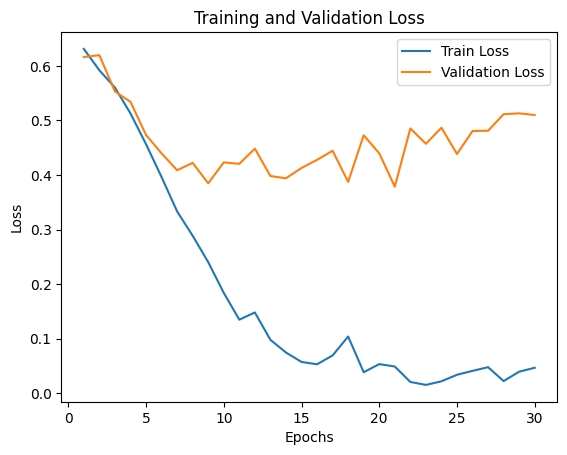

Precision: 0.8756033486283293, Recall: 0.8755760368663594, F1 Score: 0.8755150924621562
Confusion Matrix:
[[403  50]
 [ 58 357]]


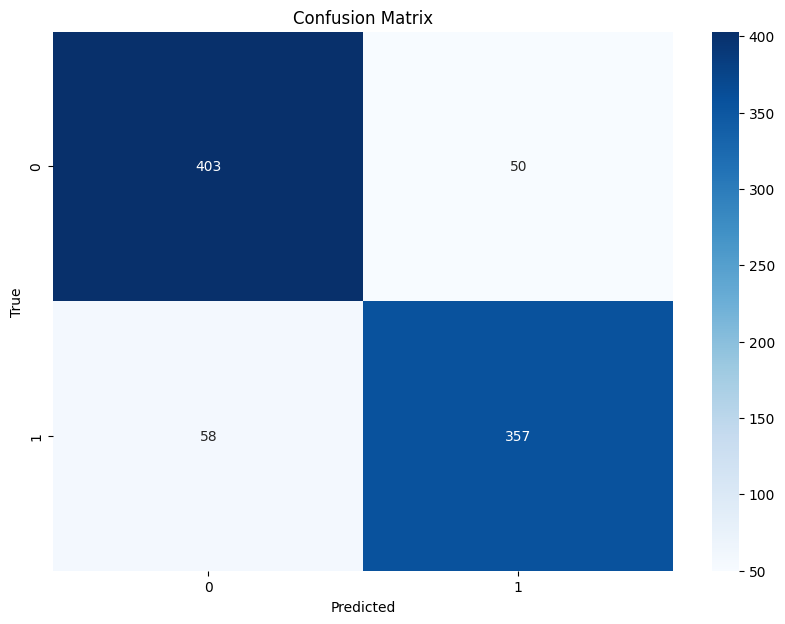

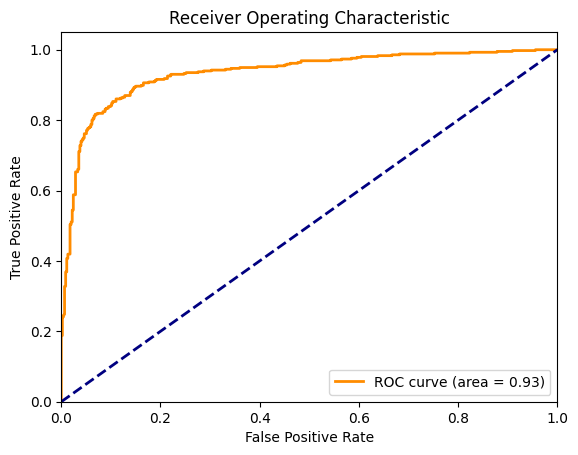

In [ ]:
print(f'Best Model Validation Loss: {val_loss}')
print(f'Best Model Accuracy: {accuracy}%')

plt.figure()
epochs = range(1, len(val_losses) + 1)
plt.plot(epochs, train_losses[:len(val_losses)], label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Final results
report = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
print(f'Precision: {report[0]}, Recall: {report[1]}, F1 Score: {report[2]}')
print('Confusion Matrix:')
print(cm)

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC curve
auc = roc_auc_score(all_labels, all_probs)
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



## Training My CNN


In this section, we train the artificial CNN model using the original and augmented datasets. The model is trained for

- 200 epochs
- **Batch size** = 64
- **Optimizer** : Adam with 0.001 learning rate
- **Cross Entropy Loss**

The loss which the model evaluates is Cross Entropy

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on device: {device}')

model_cnn = my_cnn().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

Training on device: cuda


In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load original dataset
original_dataset = datasets.ImageFolder(root=r'/content/drive/MyDrive/train_val', transform=transform)

# Load augmented dataset
augmented_dataset = datasets.ImageFolder(root=r'/content/drive/MyDrive/augmentation_train_val', transform=transform)

# Concatenate datasets
combined_dataset = ConcatDataset([original_dataset, augmented_dataset])

# Split combined dataset into training and validation sets
train_size = int(0.8 * len(combined_dataset))
val_size = len(combined_dataset) - train_size
train_dataset, val_dataset = random_split(combined_dataset, [train_size, val_size], generator=generator1)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
num_epochs = 200
patience = 10  # Number of epochs to wait for improvement before stopping
early_stop_counter = 0

train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_state = None

start_time_train = time.time()
for epoch in range(num_epochs):
    model_cnn.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    # Validation
    model_cnn.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_probs = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_cnn(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(outputs.softmax(dim=1)[:, 1].cpu().numpy())

    accuracy = 100 * correct / total
    train_losses.append(running_train_loss / len(train_loader))
    val_losses.append(running_val_loss / len(val_loader))

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Train Loss: {train_losses[-1]}, '
          f'Validation Loss: {val_losses[-1]}, '
          f'Accuracy: {accuracy}%')

    # Early stopping
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        best_model_state = model_cnn.state_dict()
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

end_time_train = time.time()
elapsed_time_train = end_time_train - start_time_train
hours_train, rem_train = divmod(elapsed_time_train, 3600)
minutes_train, seconds_train = divmod(rem_train, 60)
print(f"Training completed in :  {int(hours_train)}h {int(minutes_train)}m {int(seconds_train)}s")

# Save the best model
model_save_path = r'/content/drive/MyDrive/model_cnn.pt'
torch.save(best_model_state, model_save_path)
print(f'Model saved to {model_save_path}')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1/200, Train Loss: 6.794757924296639, Validation Loss: 1.0275644702570779, Accuracy: 49.654377880184335%
Epoch 2/200, Train Loss: 0.8422718492421237, Validation Loss: 0.6881207312856402, Accuracy: 63.0184331797235%
Epoch 3/200, Train Loss: 0.6961522600867531, Validation Loss: 0.6524775496550969, Accuracy: 65.43778801843318%
Epoch 4/200, Train Loss: 0.6792060223492709, Validation Loss: 0.6510400559220996, Accuracy: 62.21198156682028%
Epoch 5/200, Train Loss: 0.6392445249990983, Validation Loss: 0.6242245818887439, Accuracy: 64.86175115207374%
Epoch 6/200, Train Loss: 0.6175125246698207, Validation Loss: 0.616950409752982, Accuracy: 67.51152073732719%
Epoch 7/200, Train Loss: 0.6059883562001315, Validation Loss: 0.6040359735488892, Accuracy: 67.85714285714286%
Epoch 8/200, Train Loss: 0.6088831939480521, Validation Loss: 0.5743526773793357, Accuracy: 70.96774193548387%
Epoch 9/200, Train Loss: 0.5907730005004189, Validation Loss: 0.587120166846684, Accuracy: 74.30875576036867%
Epoc

### Metrics for my CNN

The model's performance is evaluated using accuracy, precision, recall, f1 score, confusion matrix and ROC curve.

In [ ]:
# Load the best model for evaluation
model_cnn.load_state_dict(best_model_state)

# Evaluate
model_cnn.eval()
running_val_loss = 0.0
correct = 0
total = 0
all_labels = []
all_preds = []
all_probs = []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_cnn(images)
        loss = criterion(outputs, labels)
        running_val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(outputs.softmax(dim=1)[:, 1].cpu().numpy())

accuracy = 100 * correct / total
val_loss = running_val_loss / len(val_loader)

Best Model Validation Loss: 0.29416473263076376
Best Model Accuracy: 89.74654377880184%


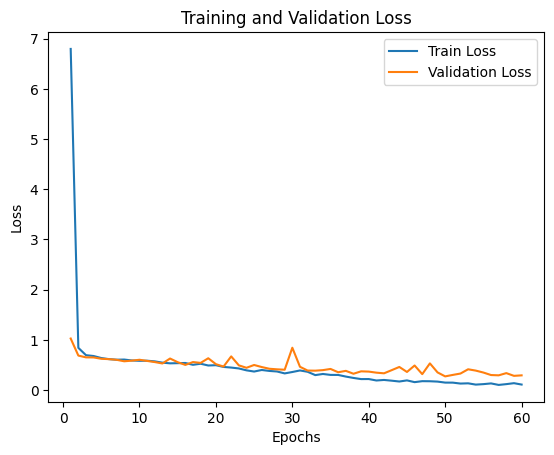

Precision: 0.8976315456056194, Recall: 0.8974654377880185, F1 Score: 0.8974039232976174
Confusion Matrix:
[[410  39]
 [ 50 369]]


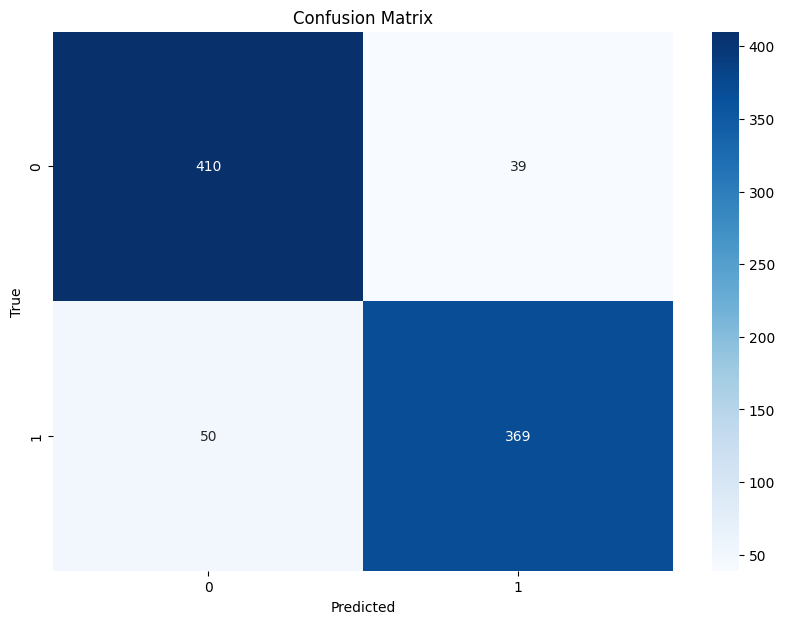

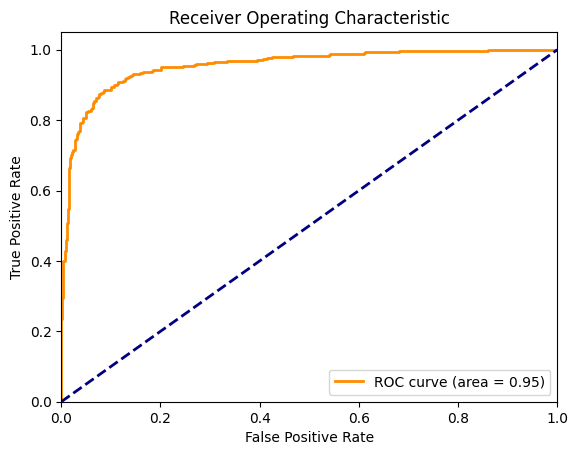

In [ ]:
print(f'Best Model Validation Loss: {val_loss}')
print(f'Best Model Accuracy: {accuracy}%')

plt.figure()
epochs = range(1, len(val_losses) + 1)
plt.plot(epochs, train_losses[:len(val_losses)], label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Final results
report = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
print(f'Precision: {report[0]}, Recall: {report[1]}, F1 Score: {report[2]}')
print('Confusion Matrix:')
print(cm)

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC curve
auc = roc_auc_score(all_labels, all_probs)
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Evaluation with Test Sets

In this section, we evaluate the performance of the trained model on the test set. We will load the test dataset, perform predictions using the trained model, and compute various evaluation metrics such as accuracy, precision, recall, F1 score, confusion matrix, and ROC curve.


### Reading test data and tranform them for Lenet

In [ ]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

my_test_dataset = datasets.ImageFolder(root=r'/content/drive/MyDrive/my_test', transform=transform)
my_test_loader = DataLoader(my_test_dataset, batch_size=32, shuffle=False, num_workers=2)

test_data_dataset = datasets.ImageFolder(root=r'/content/drive/MyDrive/test_data', transform=transform)
test_data_loader = DataLoader(test_data_dataset, batch_size=32, shuffle=False, num_workers=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Evaluating on device: {device}')

Evaluating on device: cuda


###Testing Lenet-5


Evaluating on my_test set:
My Test Accuracy: 0.56
My Test Precision: 0.56
My Test Recall: 0.56
My Test F1 Score: 0.55


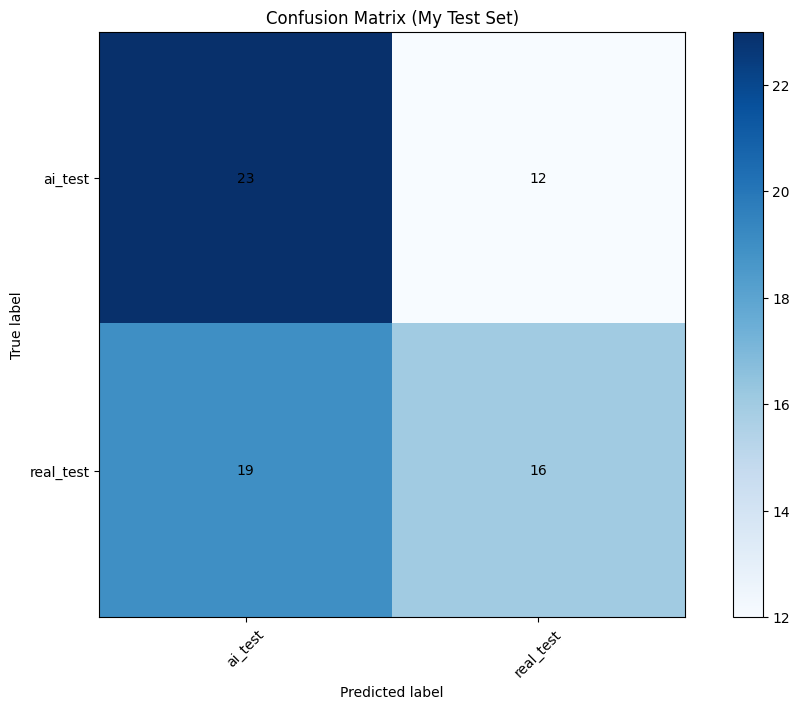

Misclassified images in my_test set:


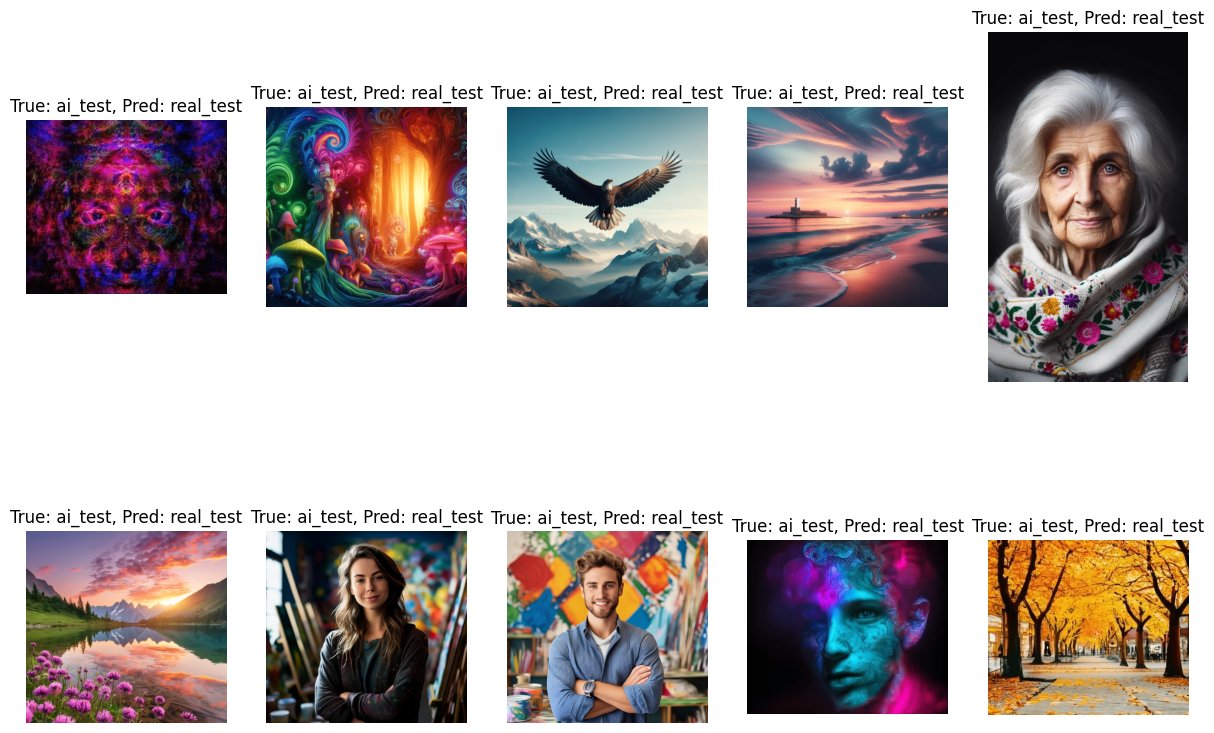

Evaluating on test_data set:
Test Data Accuracy: 0.62
Test Data Precision: 0.62
Test Data Recall: 0.62
Test Data F1 Score: 0.62


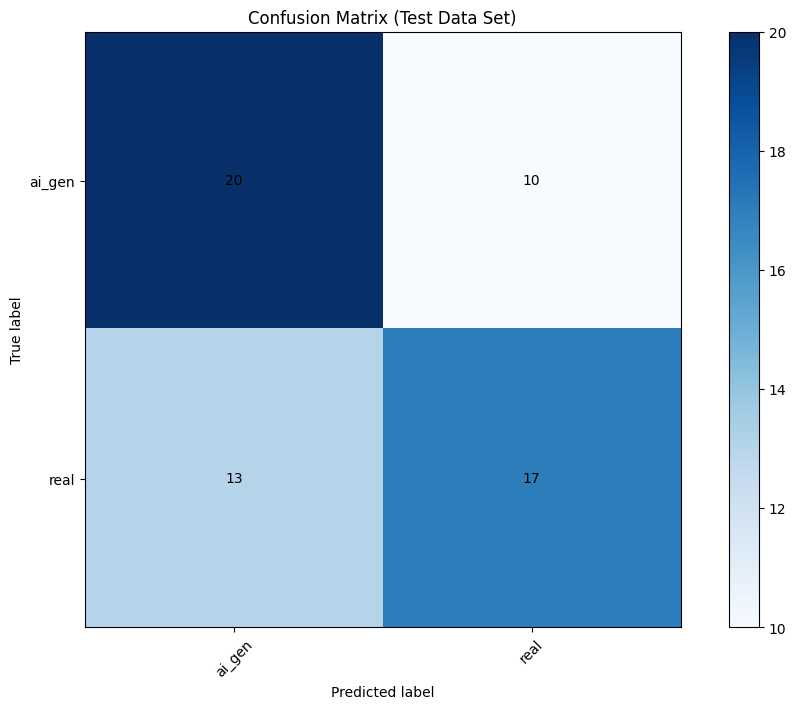

Misclassified images in test_data set:


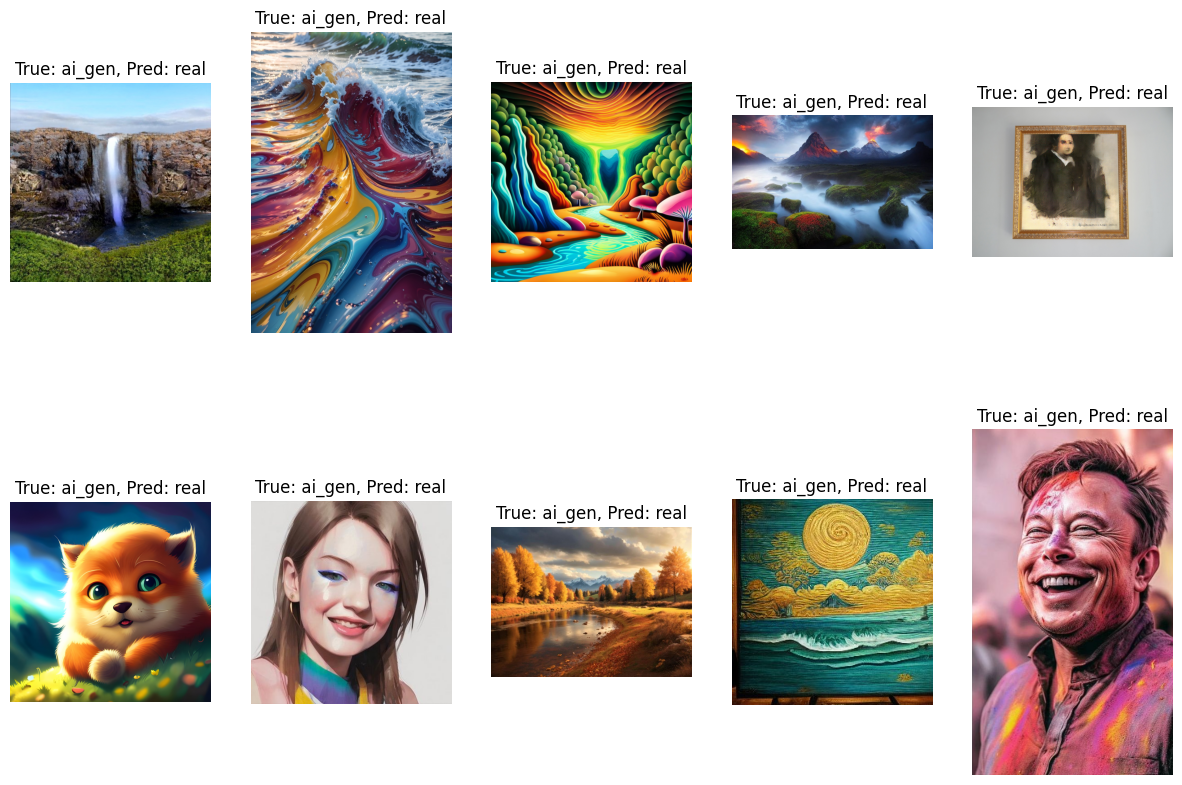

In [ ]:
def evaluate_model(model, device, test_loader, dataset_classes):
    model.eval()
    test_correct = 0
    test_total = 0
    test_all_labels = []
    test_all_preds = []
    misclassified_info = []

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            test_all_labels.extend(labels.cpu().numpy())
            test_all_preds.extend(predicted.cpu().numpy())

            # Identify misclassified samples and store their info
            for i in range(len(labels)):
                if predicted[i] != labels[i]:
                    misclassified_info.append({
                        'path': test_loader.dataset.samples[(batch_idx * test_loader.batch_size) + i][0],
                        'true_label': labels[i].cpu().numpy(),
                        'predicted_label': predicted[i].cpu().numpy()
                    })

    test_accuracy = accuracy_score(test_all_labels, test_all_preds)
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_all_labels, test_all_preds, average='weighted')
    test_cm = confusion_matrix(test_all_labels, test_all_preds)

    return test_accuracy, test_precision, test_recall, test_f1, test_cm, misclassified_info

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 verticalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def plot_misclassified_images(misclassified_info, dataset_classes, n_images=10):
    plt.figure(figsize=(15, 10))
    for idx, mis_info in enumerate(misclassified_info[:n_images]):
        img_path = mis_info['path']
        image = Image.open(img_path)
        true_label = dataset_classes[mis_info['true_label']]
        predicted_label = dataset_classes[mis_info['predicted_label']]

        plt.subplot(2, n_images // 2, idx + 1)
        plt.imshow(image)
        plt.title(f'True: {true_label}, Pred: {predicted_label}')
        plt.axis('off')
    plt.show()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the trained model
model_t_lenet = lenet(num_classes=2).to(device)
model_load_path = r'/content/drive/MyDrive/model_lenet_5.pt'
model_t_lenet.load_state_dict(torch.load(model_load_path, map_location=device))

# Evaluation on my_test set
print("Evaluating on my_test set:")
my_test_accuracy, my_test_precision, my_test_recall, my_test_f1, my_test_cm, my_test_misclassified_info = evaluate_model(model_t_lenet, device, my_test_loader, my_test_dataset.classes)
print(f'My Test Accuracy: {my_test_accuracy:.2f}')
print(f'My Test Precision: {my_test_precision:.2f}')
print(f'My Test Recall: {my_test_recall:.2f}')
print(f'My Test F1 Score: {my_test_f1:.2f}')
plot_confusion_matrix(my_test_cm, my_test_dataset.classes, title='Confusion Matrix (My Test Set)')

# Plot misclassified images
print(f'Misclassified images in my_test set:')
plot_misclassified_images(my_test_misclassified_info, my_test_dataset.classes)

# Evaluation on test_data set
print("Evaluating on test_data set:")
test_data_accuracy, test_data_precision, test_data_recall, test_data_f1, test_data_cm, test_data_misclassified_info = evaluate_model(model_t_lenet, device, test_data_loader, test_data_dataset.classes)
print(f'Test Data Accuracy: {test_data_accuracy:.2f}')
print(f'Test Data Precision: {test_data_precision:.2f}')
print(f'Test Data Recall: {test_data_recall:.2f}')
print(f'Test Data F1 Score: {test_data_f1:.2f}')
plot_confusion_matrix(test_data_cm, test_data_dataset.classes, title='Confusion Matrix (Test Data Set)')

# Plot misclassified images
print(f'Misclassified images in test_data set:')
plot_misclassified_images(test_data_misclassified_info, test_data_dataset.classes)

### Reading test data and tranform them for CNN

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

my_test_dataset = datasets.ImageFolder(root=r'/content/drive/MyDrive/my_test', transform=transform)
my_test_loader = DataLoader(my_test_dataset, batch_size=64, shuffle=False, num_workers=2)

test_data_dataset = datasets.ImageFolder(root=r'/content/drive/MyDrive/test_data', transform=transform)
test_data_loader = DataLoader(test_data_dataset, batch_size=64, shuffle=False, num_workers=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Evaluating on device: {device}')

Evaluating on device: cuda


### Testing my CNN

Evaluating on my_test set:
My Test Accuracy: 0.50
My Test Precision: 0.50
My Test Recall: 0.50
My Test F1 Score: 0.50


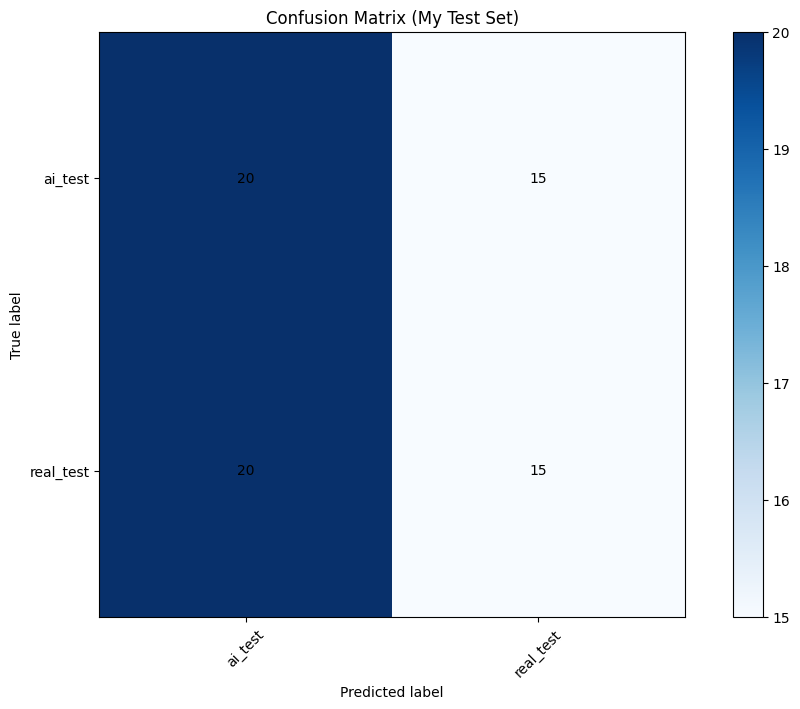

Misclassified images in my_test set:


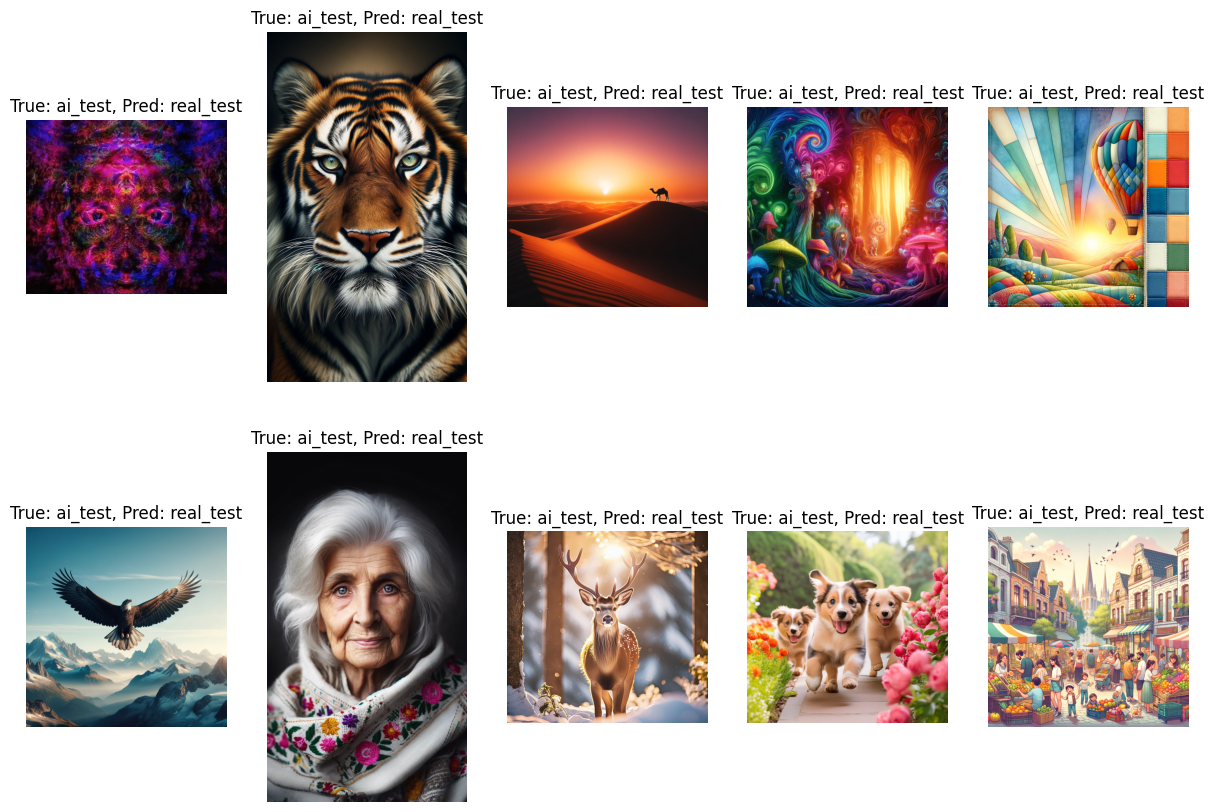

Evaluating on test_data set:


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Test Data Accuracy: 0.72
Test Data Precision: 0.72
Test Data Recall: 0.72
Test Data F1 Score: 0.72


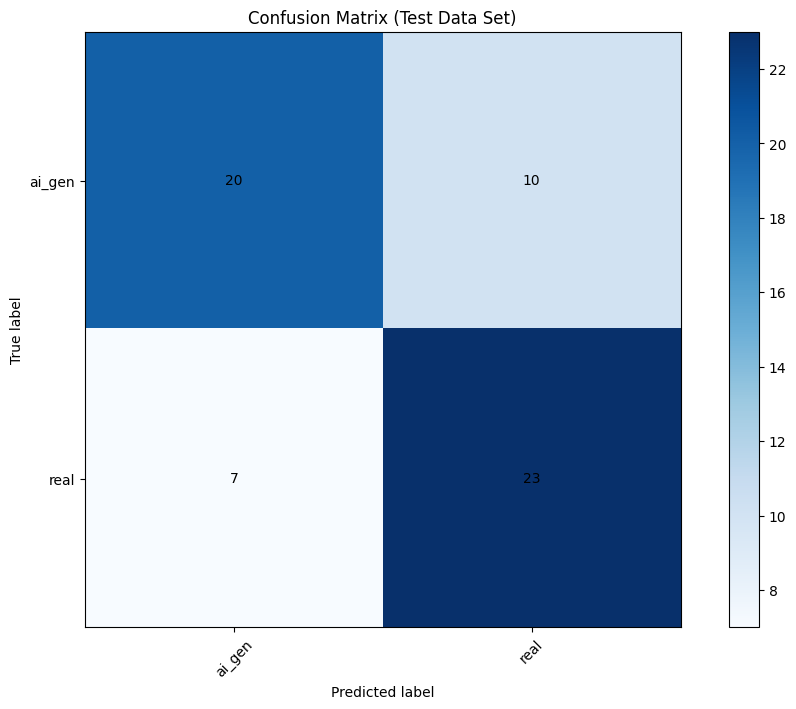

Misclassified images in test_data set:


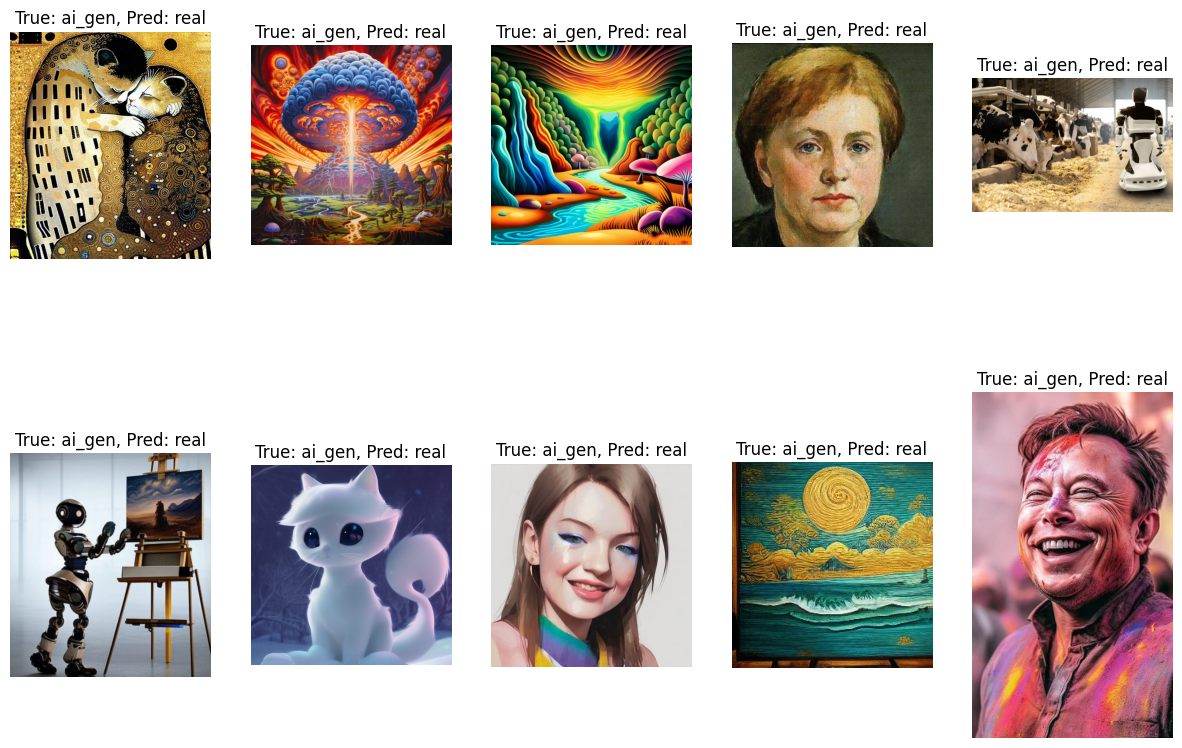

In [ ]:
def evaluate_model(model, device, test_loader, dataset_classes):
    model.eval()
    test_correct = 0
    test_total = 0
    test_all_labels = []
    test_all_preds = []
    misclassified_info = []

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            test_all_labels.extend(labels.cpu().numpy())
            test_all_preds.extend(predicted.cpu().numpy())

            # Identify misclassified samples and store their info
            for i in range(len(labels)):
                if predicted[i] != labels[i]:
                    misclassified_info.append({
                        'path': test_loader.dataset.samples[(batch_idx * test_loader.batch_size) + i][0],
                        'true_label': labels[i].cpu().numpy(),
                        'predicted_label': predicted[i].cpu().numpy()
                    })

    test_accuracy = accuracy_score(test_all_labels, test_all_preds)
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_all_labels, test_all_preds, average='weighted')
    test_cm = confusion_matrix(test_all_labels, test_all_preds)

    return test_accuracy, test_precision, test_recall, test_f1, test_cm, misclassified_info

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 verticalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def plot_misclassified_images(misclassified_info, dataset_classes, n_images=10):
    plt.figure(figsize=(15, 10))
    for idx, mis_info in enumerate(misclassified_info[:n_images]):
        img_path = mis_info['path']
        image = Image.open(img_path)
        true_label = dataset_classes[mis_info['true_label']]
        predicted_label = dataset_classes[mis_info['predicted_label']]

        plt.subplot(2, n_images // 2, idx + 1)
        plt.imshow(image)
        plt.title(f'True: {true_label}, Pred: {predicted_label}')
        plt.axis('off')
    plt.show()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the trained model
model_t_cnn = my_cnn(num_classes=2).to(device)
model_load_path = r'/content/drive/MyDrive/model_cnn.pt'
model_t_cnn.load_state_dict(torch.load(model_load_path, map_location=device))

# Evaluation on my_test set
print("Evaluating on my_test set:")
my_test_accuracy, my_test_precision, my_test_recall, my_test_f1, my_test_cm, my_test_misclassified_info = evaluate_model(model_t_cnn, device, my_test_loader, my_test_dataset.classes)
print(f'My Test Accuracy: {my_test_accuracy:.2f}')
print(f'My Test Precision: {my_test_precision:.2f}')
print(f'My Test Recall: {my_test_recall:.2f}')
print(f'My Test F1 Score: {my_test_f1:.2f}')
plot_confusion_matrix(my_test_cm, my_test_dataset.classes, title='Confusion Matrix (My Test Set)')

# Plot misclassified images
print(f'Misclassified images in my_test set:')
plot_misclassified_images(my_test_misclassified_info, my_test_dataset.classes)

# Evaluation on test_data set
print("Evaluating on test_data set:")
test_data_accuracy, test_data_precision, test_data_recall, test_data_f1, test_data_cm, test_data_misclassified_info = evaluate_model(model_t_cnn, device, test_data_loader, test_data_dataset.classes)
print(f'Test Data Accuracy: {test_data_accuracy:.2f}')
print(f'Test Data Precision: {test_data_precision:.2f}')
print(f'Test Data Recall: {test_data_recall:.2f}')
print(f'Test Data F1 Score: {test_data_f1:.2f}')
plot_confusion_matrix(test_data_cm, test_data_dataset.classes, title='Confusion Matrix (Test Data Set)')

# Plot misclassified images
print(f'Misclassified images in test_data set:')
plot_misclassified_images(test_data_misclassified_info, test_data_dataset.classes)


## Support Vector Machines (SVM)

Support Vector Machines are a popular choice for binary classification tasks. We use the features extracted from the images using a pretrained Resnet-16 to train an SVM classifier. We implement k - folds validation for statistic efficiency and after a grid search
the best hyperparameters are
- C = 1.7
- gamma = 1/n_features = 0.002

Training for 5 folds completed in :  0h 0m 53s


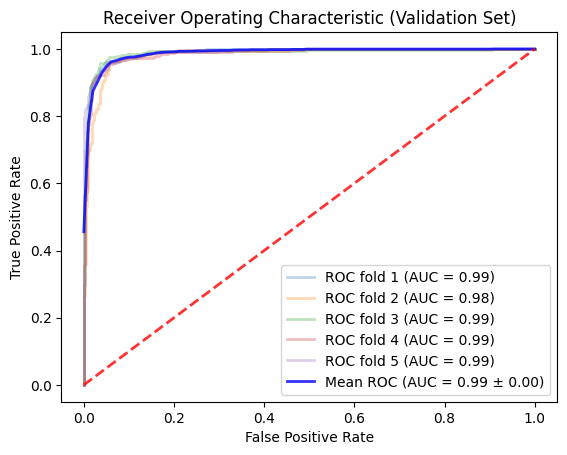

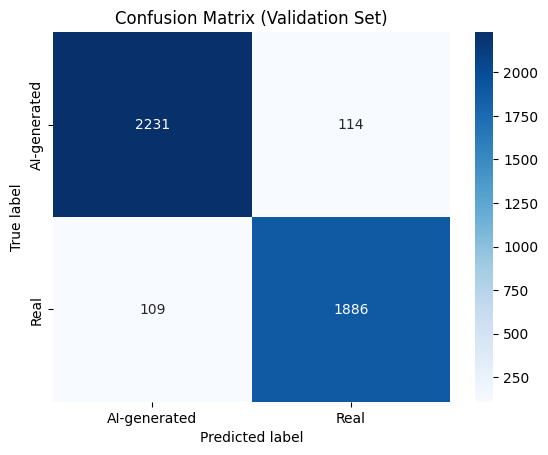

Mean Accuracy: 0.95 ± 0.00
Mean Precision: 0.94 ± 0.02
Mean Recall: 0.95 ± 0.01
Mean F1 Score: 0.94 ± 0.00
Confusion Matrix (Validation Set):
[[2231.  114.]
 [ 109. 1886.]]


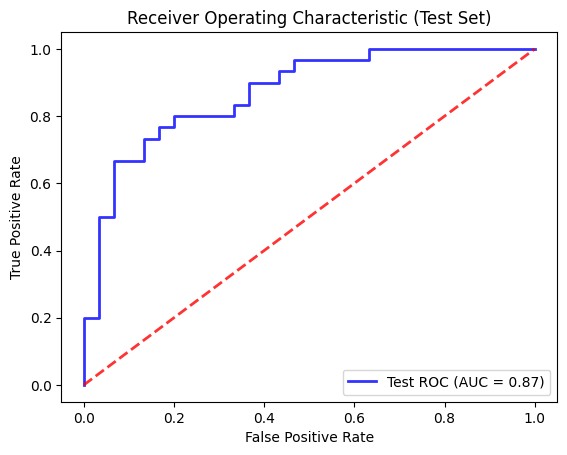

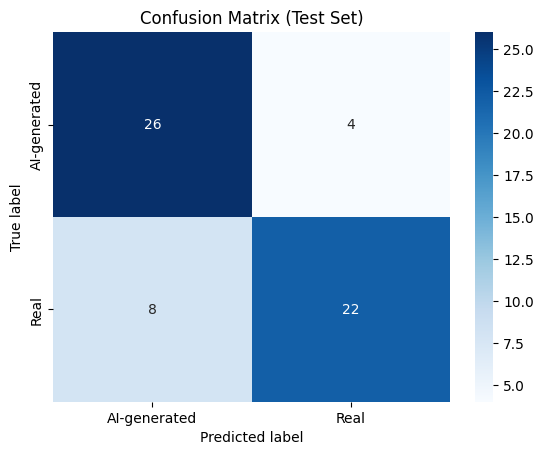

Test Accuracy: 0.80
Test Precision: 0.85
Test Recall: 0.73
Test F1 Score: 0.79
Confusion Matrix (Test Set):
[[26  4]
 [ 8 22]]


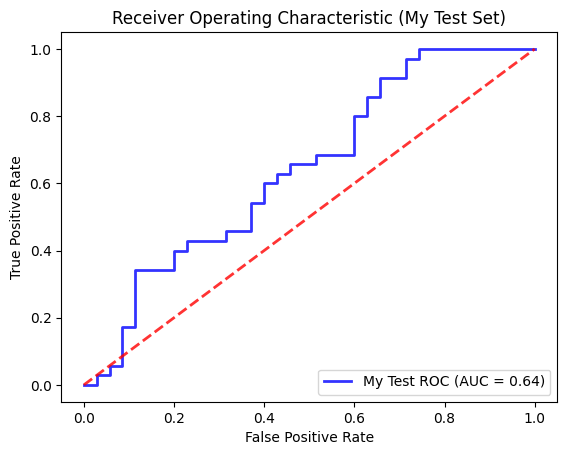

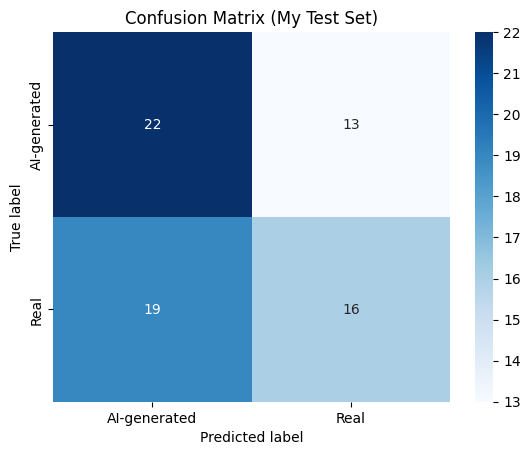

My Test Accuracy: 0.54
My Test Precision: 0.55
My Test Recall: 0.46
My Test F1 Score: 0.50
Confusion Matrix (My Test Set):
[[22 13]
 [19 16]]


In [ ]:
start_time_train = time.time()

# Load training set
train_df = pd.read_csv(r'/content/drive/MyDrive/features.csv')

X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values

# Load test set
test_df = pd.read_csv(r'/content/drive/MyDrive/test_features.csv')

X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values

# Load extra test set
my_test_df = pd.read_csv(r'/content/drive/MyDrive/my_test_features.csv')

X_my_test = my_test_df.drop('label', axis=1).values
y_my_test = my_test_df['label'].values

svm_classifier = SVC(kernel='rbf', C=1.7, gamma=0.002, random_state=42, probability=True)

# Set up k-folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
precisions = []
recalls = []
f1_scores = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
conf_matrix = np.zeros((2, 2))

# K-folds
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Train
    svm_classifier.fit(X_train_fold, y_train_fold)

    # Validation
    y_val_pred = svm_classifier.predict(X_val_fold)
    y_val_prob = svm_classifier.predict_proba(X_val_fold)[:, 1]

    accuracies.append(accuracy_score(y_val_fold, y_val_pred))
    precisions.append(precision_score(y_val_fold, y_val_pred))
    recalls.append(recall_score(y_val_fold, y_val_pred))
    f1_scores.append(f1_score(y_val_fold, y_val_pred))
    conf_matrix += confusion_matrix(y_val_fold, y_val_pred)

    fpr, tpr, _ = roc_curve(y_val_fold, y_val_prob)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label=f'ROC fold {len(aucs)} (AUC = {roc_auc:.2f})')

end_time_train = time.time()
elapsed_time_train = end_time_train - start_time_train
hours_train, rem_train = divmod(elapsed_time_train, 3600)
minutes_train, seconds_train = divmod(rem_train, 60)
print(f"Training for 5 folds completed in :  {int(hours_train)}h {int(minutes_train)}m {int(seconds_train)}s")

# Plot mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2, alpha=0.8)
plt.plot([0, 1], [0, 1], linestyle='--', color='r', lw=2, alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Validation Set)')
plt.legend(loc='lower right')
plt.show()

# Plot confusion matrix
labels = ['AI-generated', 'Real']
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (Validation Set)')
plt.show()

print(f"Mean Accuracy: {np.mean(accuracies):.2f} ± {np.std(accuracies):.2f}")
print(f"Mean Precision: {np.mean(precisions):.2f} ± {np.std(precisions):.2f}")
print(f"Mean Recall: {np.mean(recalls):.2f} ± {np.std(recalls):.2f}")
print(f"Mean F1 Score: {np.mean(f1_scores):.2f} ± {np.std(f1_scores):.2f}")
print("Confusion Matrix (Validation Set):")
print(conf_matrix)

# Train on the whole training set
svm_classifier.fit(X_train, y_train)

# Evaluate on the test set
y_test_pred = svm_classifier.predict(X_test)
y_test_prob = svm_classifier.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

test_fpr, test_tpr, _ = roc_curve(y_test, y_test_prob)
test_roc_auc = auc(test_fpr, test_tpr)
plt.plot(test_fpr, test_tpr, color='b', label=f'Test ROC (AUC = {test_roc_auc:.2f})', lw=2, alpha=0.8)
plt.plot([0, 1], [0, 1], linestyle='--', color='r', lw=2, alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Test Set)')
plt.legend(loc='lower right')
plt.show()

sns.heatmap(test_conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (Test Set)')
plt.show()

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
print(f"Test F1 Score: {test_f1:.2f}")
print("Confusion Matrix (Test Set):")
print(test_conf_matrix)

# Evaluate on the my_test set
y_my_test_pred = svm_classifier.predict(X_my_test)
y_my_test_prob = svm_classifier.predict_proba(X_my_test)[:, 1]

my_test_accuracy = accuracy_score(y_my_test, y_my_test_pred)
my_test_precision = precision_score(y_my_test, y_my_test_pred)
my_test_recall = recall_score(y_my_test, y_my_test_pred)
my_test_f1 = f1_score(y_my_test, y_my_test_pred)
my_test_conf_matrix = confusion_matrix(y_my_test, y_my_test_pred)

my_test_fpr, my_test_tpr, _ = roc_curve(y_my_test, y_my_test_prob)
my_test_roc_auc = auc(my_test_fpr, my_test_tpr)
plt.plot(my_test_fpr, my_test_tpr, color='b', label=f'My Test ROC (AUC = {my_test_roc_auc:.2f})', lw=2, alpha=0.8)
plt.plot([0, 1], [0, 1], linestyle='--', color='r', lw=2, alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (My Test Set)')
plt.legend(loc='lower right')
plt.show()

sns.heatmap(my_test_conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (My Test Set)')
plt.show()

print(f"My Test Accuracy: {my_test_accuracy:.2f}")
print(f"My Test Precision: {my_test_precision:.2f}")
print(f"My Test Recall: {my_test_recall:.2f}")
print(f"My Test F1 Score: {my_test_f1:.2f}")
print("Confusion Matrix (My Test Set):")
print(my_test_conf_matrix)


## Conclusion

The project successfully demonstrated the capability of both deep learning and traditional machine learning methods in distinguishing AI-generated images from real images. The custom CNN achieved promising results. However, the project also highlighted the challenges associated with generalizing the model, fine-tuning its parameters, and achieving high performance metrics with limited resources. This underscores the importance of comprehensive data quality, extensive computational power, and robust model tuning in developing high-performing deep learning models. The use of a pre-trained ResNet-18 for feature extraction, combined with an SVM classifier, demonstrated the effectiveness of state-of-the-art. This approach not only leverages the powerful feature extraction capabilities of ResNet-18 but also underscores the necessity of extensive data for achieving superior performance in image classification tasks.

In addition, this project highlighted the critical importance of having good quality data. The initial exploration of the dataset revealed the need for rigorous preprocessing, such as cropping out irrelevant parts and splitting concatenated images. Ensuring the quality of data through meticulous preprocessing steps significantly contributed to the effectiveness of the models.

Overall, this project emphasizes the importance of comprehensive data preprocessing, the effectiveness of data augmentation, and the potential of deep learning models in image classification tasks.

